In [19]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct Agent"

In [20]:
## Custom Function
def multiply(a:int, b:int)->int:
    """
    Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int, b:int)->int:
    """
    Adds a and b
    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a:int, b:int)->int:
    """ 
    Divides a and b
    Args:
        a: first int
        b: second int
    """
    return a/b

In [21]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults(max_results=5)

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [22]:
tavily.invoke("Give me latest AI newsof March 2025")

[{'title': 'Top 5 AI trends in March 2025: AI agents, smarter supply ... - Neudesic',
  'url': 'https://www.neudesic.com/blog/top-5-ai-trends-march-2025/',
  'content': 'March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to Microsoft’s external knowledge integration approach, this month’s highlights underscore how artificial intelligence is evolving in ways that matter today, not just tomorrow. Whether it’s optimizing supply chains, pushing the limits of robotics, or making AI systems smarter and more trustworthy, [...] Below, we delve into five top AI trends from March 2025 and explore the practical ways they’re changing industries—from retail to robotics—and setting the stage for what’s ahead. \n\n## 1. OpenAI Releases New Tools for Building AI Agents [...] This month’s advancements in AI reinforce a clear trajectory: artificial intellig

In [23]:
tools = [add, multiply, divide, tavily, arxiv, wiki]

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [25]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

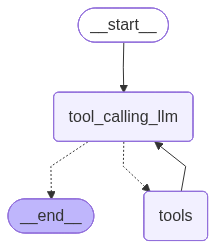

In [26]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_condition_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_condition_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [27]:
messages = graph.invoke({"messages":HumanMessage(content = "Search the internet and give me the 5 latest AI news from Tavily, add 5 plus 5 and then multiply by 10")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Search the internet and give me the 5 latest AI news from Tavily, add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_SizKHTgkYVMZQxQGh7n5vZ8S)
 Call ID: call_SizKHTgkYVMZQxQGh7n5vZ8S
  Args:
    query: latest AI news
  add (call_VBVr6Witq5nJOhkhRiqSKOl5)
 Call ID: call_VBVr6Witq5nJOhkhRiqSKOl5
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "8 Key AI Developments Shaping 2025 - Koombea", "url": "https://ai.koombea.com/blog/key-ai-developments", "content": "From powerful generative chatbots to AI-driven drug discovery, the latest AI trends and developments are creating opportunities and challenges that tech decision-makers can’t ignore. Staying current with artificial intelligence news is ess

In [29]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
grapy_with_memory = builder.compile(checkpointer=memory)


In [30]:
config = {"configurable":{"thread_id":"1"}}

grapy_with_memory.invoke({"messages":"Add 2 + 2"}, config=config)

{'messages': [HumanMessage(content='Add 2 + 2', additional_kwargs={}, response_metadata={}, id='c9bee369-34e0-4e95-9f89-754f623c215e'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 318, 'total_tokens': 335, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_672b6a21ba', 'id': 'chatcmpl-ChBCtlfjBmVZX2l7XXUaL8e9kNlHQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--fffe5b86-b986-4a2f-852c-33fa84bdcb45-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_c8drv6qBIhxvhAVOGnf0bstf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 318, 'output_tokens': 17, 'total_tokens': 335, 'input_token_detail

In [31]:
grapy_with_memory.invoke({"messages":"what question did ask"}, config=config)

{'messages': [HumanMessage(content='Add 2 + 2', additional_kwargs={}, response_metadata={}, id='c9bee369-34e0-4e95-9f89-754f623c215e'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 318, 'total_tokens': 335, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_672b6a21ba', 'id': 'chatcmpl-ChBCtlfjBmVZX2l7XXUaL8e9kNlHQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--fffe5b86-b986-4a2f-852c-33fa84bdcb45-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_c8drv6qBIhxvhAVOGnf0bstf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 318, 'output_tokens': 17, 'total_tokens': 335, 'input_token_detail